# Preprocessing
Splice August 28-December 3 data into training and validation sets

In [1]:
# import packages  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
import os

os.chdir('/Users/Aldis/Documents/MATLAB/ES100/Dataset4/')

# Import and rename columns

In [2]:
# from filedrop into new folder dataset4, import directly
# read_csv with delimiter as a semicolon, rename headers, 
# parse dates as indices! 
def rename(file_csv, names_array):
    ''' uses pd.read_csv to quickly read and rename new imported 
    datasets, give the name of the file (e.g. 'aq4.csv', 
    and the names_array = ['occ', 'co2',...])
    returns dataset with an abbreviation of your choice (output)'''
    
    dataset = pd.read_csv(file_csv, delimiter = ';',
                         parse_dates = [0], index_col = [0],
                         header = 0, names = names_array)
    
    dataseries = pd.DataFrame(dataset, dtype = float) 
    # to be able to resample later: https://stackoverflow.com/
    # questions/12844529/no-numeric-types-to-aggregate-
    # change-in-groupby-behaviour

    return dataseries

# Single data streams with ºF to ºC conversion

In [3]:
# convert fahrenheit values to C and replace that (first) 
# column of the dataset
def convert2C(singlestream, replace_col):
    ''' F to C conversion '''
    arrayC = np.zeros(len(singlestream.values))
    for i in np.arange(0, len(singlestream.values),1):
        arrayC[i] = (5/9)*(singlestream.values[i].astype('float')-32)
    arrayC # not good, it rounds
    singlestream.iloc[:,replace_col] = np.transpose(arrayC)
    return singlestream

# Import

In [4]:
# importing them separately allows us to interpolate immediately
# but requires more concatenation later
blinds = rename('blinds.csv',['blinds'])
co2 = rename('co2.csv',['co2'])
heatstat = rename('heatstat.csv', ['heatstat'])
heatvalve = rename('heatvalve.csv',['heatvalve'])
heatvalvestat = rename('heatvalvestat.csv', ['heatvalvestat'])
humid = rename('humid.csv', ['humid'])

occ = rename('occ.csv', ['occ'])
positR = rename('positR.csv', ['positR'])
positS = rename('positS.csv', ['positS'])
qfresh = rename('qfresh.csv', ['qfresh'])
rain = rename('rain.csv', ['rain'])

humid31 = rename('rm31loungehumid.csv',['humid31'])
occ31 = rename('rm31loungeocc.csv',['occ31'])
temp31 = rename('rm31loungetemp.csv',['temp31'])
humid33 = rename('rm33officehumid.csv',['humid33'])
occ33 = rename('rm33officeocc.csv',['occ33'])
temp33 = rename('rm33officetemp.csv',['temp33'])

In [5]:
# surrounding room conditions
temp2223 = rename('rm2223temp.csv',['temp23', 'temp22'])
temp22 = temp2223.iloc[:,1] # contains temp 22 and temp 23
temp23 = temp2223.iloc[:,0] # separate them as columns

humid2223 = rename('rm2223humid.csv',['humid22', 'humid23'])
humid22 = humid2223.iloc[:,0] # separate humid 22, humid23
humid23 = humid2223.iloc[:,1]

In [6]:
oatC = rename('oatF.csv', ['oatC']) # pre-emptively renaming to oatC
oatC = convert2C(oatC, 0) # replace column 0
oatC.head()

,oatC
2018-06-27 23:57:00,20.209999
2018-06-28 00:32:00,20.010000
2018-06-28 00:34:00,20.200001
2018-06-28 00:35:00,20.080000
2018-06-28 01:24:59,19.959999


In [7]:
roomC = rename('roomsensorC.csv', ['roomC'])
slabC = rename('slabsensorC.csv', ['slabC'])
setC = rename('setptF.csv', ['setC'])
setC = convert2C(setC, 0)

# find zeros in setpoint and replace with NaN
zeros = np.where(setC == 0) 
setC.iloc[zeros] = np.NaN
display(setC.head()) # occasional blips in
# setpoint temperatures are nonsensical, such as 32, 
# so we replace them with NaN

,setC
2018-06-27 05:52:04,22.0
2018-07-05 20:07:11,NaN
2018-07-05 20:08:04,22.0
2018-07-05 21:05:03,21.0
2018-07-05 21:05:06,22.0


In [8]:
startpulsevent = rename('startpulsevent.csv', ['startpulsevent'])
ventmode = rename('ventmode.csv', ['ventmode'])
windir = rename('windir.csv', ['windir'])
windsp = rename('windsp.csv', ['windsp'])

# Handling data gaps, resampling, interpolating

In [13]:
# INTERPOLATE!
# built on interpolation function from stackoverflow:
# https://stackoverflow.com/questions/6518811/interpolate-nan-
# values-in-a-numpy-array

def interpolate(padata, pkind = 'slinear'): # spline 1st order
    '''linear interpolation
        takes in data with NaNs, and returns data with interpolated 
        values'''
    
    aindexes = np.arange(padata.shape[0])
    
    ''' adding a for loop to do this for all columns of the data'''

    # rows, columns
    interpolated = np.zeros((padata.shape[0],padata.shape[1])) 
    copy = padata # copy format of data table
    
    for i in np.arange(padata.shape[1]):
        # non NaN values
        agood_indexes, = np.where(np.isfinite(padata.iloc[:,i])) 
        f = interp1d(agood_indexes
                    , padata.iloc[agood_indexes,i]
                    , bounds_error = False
                    , copy = False
                    , fill_value = "extrapolate"
                    , kind = pkind)
        interpolated[:,i] = f(aindexes)
        copy.iloc[:,i] = interpolated[:,i] 
        # replace columns with interpolated data! IT WORKS!
        
    return copy

# another source on scipy interpolation function:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html

In [30]:
# handling data gaps either by filling with 0s or interpolating 
# (continuous datasets)

def takemeans(dataset, Ts):
    '''resample and fillna(0)'''
    datasetm = dataset.resample(Ts).mean()
    return datasetm

def cleanfill(dataset, Ts):
    '''resample and fillna(0)'''
    dataseti = dataset.resample(Ts).mean().fillna(0)
    return dataseti

def cleanfwdfill(dataset, Ts):
    '''resample and fillna(0)'''
    dataseti = dataset.resample(Ts).mean().ffill()
    return dataseti
    
def cleaninterp(dataset, Ts):
    '''resample and interpolate
        intended for continuous datastreams like temp, humidity'''
    dataseti = interpolate(dataset.resample(Ts).mean())
    return dataseti

In [31]:
# take means!
# no interpolations
# this reveals data gaps
Ts = '1T'
heatvalvestatm = takemeans(heatvalvestat,Ts)
heatvalvem = takemeans(heatvalve,Ts)
heatstatm = takemeans(heatstat,Ts)
blindsm = takemeans(blinds,Ts)
occm = takemeans(occ,Ts)
occ31m = takemeans(occ31,Ts)
occ33m = takemeans(occ33,Ts)
positRm = takemeans(positR,Ts)
positSm = takemeans(positS,Ts)
qfreshm = takemeans(qfresh,Ts)
rainm = takemeans(rain,Ts)
startpulsem = takemeans(startpulsevent,Ts)
ventmodem = takemeans(ventmode,Ts)
setCm = takemeans(setC,Ts)
co2m = takemeans(co2,Ts)
humidm = takemeans(humid,Ts)
humid31m = takemeans(humid31,Ts)
humid33m = takemeans(humid33,Ts)
humid2223m = takemeans(humid2223,Ts) # humid 22, humid 23
oatCm = takemeans(oatC,Ts)
temp31m = takemeans(temp31,Ts)
temp33m = takemeans(temp33,Ts)
temp2223m = takemeans(temp2223,Ts) # temp 23, temp 22
roomCm = takemeans(roomC,Ts)
slabCm = takemeans(slabC,Ts)
windirm = takemeans(windir,Ts)
windspm = takemeans(windsp,Ts)

In [15]:
# dealing with missing data upon resampling
# future iterations should use a for loop with names as strings + 'i'
# and just pass in an array of column variable names to resample etc.

# no interpolations
Ts = '1T'
heatvalvestati = cleanfill(heatvalvestat,Ts)
heatvalvei = cleanfill(heatvalve,Ts)
heatstati = cleanfill(heatstat,Ts)
blindsi = cleanfill(blinds,Ts)
occi = cleanfill(occ,Ts)
occ31i = cleanfill(occ31,Ts)
occ33i = cleanfill(occ33,Ts)
positRi = cleanfill(positR,Ts)
positSi = cleanfill(positS,Ts)
qfreshi = cleanfill(qfresh,Ts)
raini = cleanfill(rain,Ts)
startpulsei = cleanfill(startpulsevent,Ts)
ventmodei = cleanfill(ventmode,Ts)

## fill forward
setCi = cleanfwdfill(setC,Ts)

# # mostly interpolated
co2i = cleaninterp(co2,Ts)
humidi = cleaninterp(humid,Ts)
humid31i = cleaninterp(humid31,Ts)
humid33i = cleaninterp(humid33,Ts)
humid2223i = cleaninterp(humid2223,Ts) # humid 22, humid 23
oatCi = cleaninterp(oatC,Ts)
temp31i = cleaninterp(temp31,Ts)
temp33i = cleaninterp(temp33,Ts)
temp2223i = cleaninterp(temp2223,Ts) # temp 23, temp 22
roomCi = cleaninterp(roomC,Ts)
slabCi = cleaninterp(slabC,Ts)
windiri = cleaninterp(windir,Ts)
windspi = cleaninterp(windsp,Ts)

In [25]:
positRi.to_csv('Preprocessed/021319/positRi.csv', index = True, header = True)

# View results of interpolation / clean filling

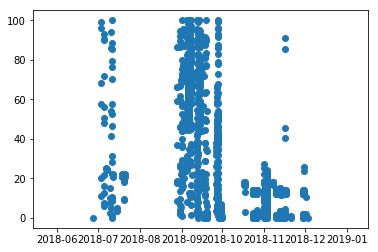

In [32]:
plt.scatter(positRm.index, positRm.iloc[:,0]) #jul-oct with data gaps

# Concatenating

In [33]:
# https://pandas.pydata.org/pandas-docs/stable/merging.html
con = pd.concat([blindsi, heatstati, heatvalvei, heatvalvestati, 
                 occi, occ31i, occ33i, positRi, positSi, 
                 qfreshi, raini, startpulsei, ventmodei,
                 co2i, humidi, humid31i, humid33i, humid2223i, 
                 oatCi,temp31i, temp33i, temp2223i, 
                 roomCi, slabCi, setCi, windiri, windspi], 
                sort = True, axis=1)

In [34]:
# Chopping NaN's, exporting clean interpolated concatenated data
full_row = con[con.iloc[:,0].notnull() 
               & con.iloc[:,1].notnull() & con.iloc[:,2].notnull()
               & con.iloc[:,3].notnull() & con.iloc[:,4].notnull() 
               & con.iloc[:,5].notnull() & con.iloc[:,6].notnull() 
               & con.iloc[:,7].notnull() & con.iloc[:,8].notnull() 
               & con.iloc[:,9].notnull() & con.iloc[:,10].notnull() 
               & con.iloc[:,11].notnull() & con.iloc[:,12].notnull()
               & con.iloc[:,13].notnull() & con.iloc[:,14].notnull() 
               & con.iloc[:,15].notnull() & con.iloc[:,16].notnull() 
               & con.iloc[:,17].notnull() & con.iloc[:,18].notnull() 
               & con.iloc[:,19].notnull() & con.iloc[:,20].notnull() 
               & con.iloc[:,21].notnull() & con.iloc[:,22].notnull() 
               & con.iloc[:,23].notnull() & con.iloc[:,24].notnull()
               & con.iloc[:,25].notnull() & con.iloc[:,26].notnull() 
               & con.iloc[:,27].notnull() & con.iloc[:,28].notnull()]

os.chdir('/Users/Aldis/Documents/MATLAB/ES100/Dataset4/')
full_row.to_csv('Preprocessed/021319/fullrow.csv', 
                index = True, header = True) # keep dates and labels
full_row.head()

,blinds,heatstat,heatvalve,heatvalvestat,occ,occ31,occ33,positR,positS,qfresh,...,oatC,temp31,temp33,temp23,temp22,roomC,slabC,setC,windir,windsp
2018-08-28 09:41:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.102608,...,31.570909,25.804828,25.922286,25.700001,25.837142,27.125778,26.364575,21.5,271.50,1.200
2018-08-28 09:42:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,...,31.581818,25.813104,25.929143,25.700001,25.855714,27.132000,26.365682,21.5,271.00,1.300
2018-08-28 09:43:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,...,31.592727,25.821380,25.936000,25.700001,25.874285,27.138222,26.366789,21.5,270.50,1.400
2018-08-28 09:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,...,31.603636,25.829656,25.942857,25.700001,25.892856,27.144444,26.367896,21.5,271.00,1.425
2018-08-28 09:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.76,0.000000,...,31.614545,25.837932,25.949714,25.700001,25.911428,27.150667,26.369003,21.5,271.25,1.450


# full row uninterpolated, leaving NAs

In [37]:
conm = pd.concat([blindsm, heatstatm, heatvalvem, heatvalvestatm, 
                  occm, occ31m, occ33m, positRm, positSm, 
                  qfreshm, rainm, startpulsem, ventmodem,
                  co2m, humidm, humid31m, humid33m, humid2223m, 
                  oatCm,temp31m, temp33m, temp2223m, 
                  roomCm, slabCm, setCm, windirm, windspi], 
                 sort = True, axis=1)
conm.head()

,blinds,heatstat,heatvalve,heatvalvestat,occ,occ31,occ33,positR,positS,qfresh,...,oatC,temp31,temp33,temp23,temp22,roomC,slabC,setC,windir,windsp
2018-04-02 14:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
2018-04-02 14:46:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001
2018-04-02 14:47:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002
2018-04-02 14:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000004
2018-04-02 14:49:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000005


In [39]:
# Chopping NaN, exporting clean interpolated concatenated data
full_rowm = conm
os.chdir('/Users/Aldis/Documents/MATLAB/ES100/Dataset4/')
full_rowm.to_csv('Preprocessed/021319/fullrow_NAs.csv', 
                 index = True, header = True)
full_rowm.tail()

,blinds,heatstat,heatvalve,heatvalvestat,occ,occ31,occ33,positR,positS,qfresh,...,oatC,temp31,temp33,temp23,temp22,roomC,slabC,setC,windir,windsp
2018-12-03 11:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.5,3.275
2018-12-03 11:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,318.0,3.250
2018-12-03 11:43:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.225
2018-12-03 11:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.200
2018-12-03 11:45:00,0.0,33.0,100.0,100.0,-1.0,0.0,0.0,0.0,0.0,0.01328,...,14.68,16.34,16.42,16.32,17.52,16.9,17.799999,21.0,318.0,3.200


# Visualize the variables in the model

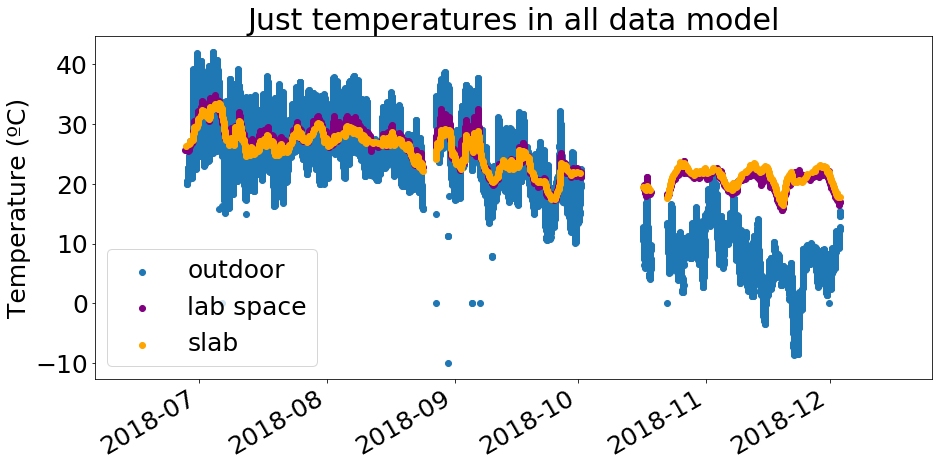

In [52]:
plt.rcParams['font.size'] = 25 # font size

fig, ax = plt.subplots(figsize = (15,7)) # dimensions
ax.xaxis_date() # set_major_formatter(mdates.DateFormatter('%m/%d')) # ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.scatter(full_rowm.index, full_rowm.oatC, label = 'outdoor')
ax.scatter(full_rowm.index, full_rowm.roomC, label = 'lab space', color = 'purple')
ax.scatter(full_rowm.index, full_rowm.slabC, label = 'slab', color = 'orange')

# ax.scatter(full_rowm.index, full_rowm.temp22, label = 'room 22')
# ax.scatter(full_rowm.index, full_rowm.temp23, label = 'room 23')
# ax.scatter(full_rowm.index, full_rowm.temp31, label = 'room 31')
# ax.scatter(full_rowm.index, full_rowm.temp33, label = 'room 33')

ax.legend()
ax.set_ylabel('Temperature (ºC)')
fig.autofmt_xdate()
ax.set_title('Just temperatures in all data model');
plt.savefig('Plots/021319/justemps_select_NAs.png')

In [218]:
np.max(roomCi.diff()) # highest jump in temperature between intervals

roomC    0.429999
dtype: float64



# Training-validation split, before and after split

In [62]:
# if we take the second and third largest then
# the longest data gap between oct 2 and 26 will be removed
def second_largest(lengths):
    secondplace = -np.sort(-lengths)[1]
    return secondplace
def third_largest(lengths):
    thirdplace = -np.sort(-lengths)[2] 
    #https://stackoverflow.com/questions/26984414/efficiently-
    #sorting-a-numpy-array-in-descending-order
    return thirdplace
def fourth_largest(lengths): # for the sake of unoccupied condition
    fourthplace = -np.sort(-lengths)[3]
    return fourthplace

# save the files
def file_away(train, valid, tstring, vstring):
    ''' places training and validation sets into folder below '''
    filenameT = 'Preprocessed/021319/' + tstring + '.csv'
    filenameV = 'Preprocessed/021319/' + vstring + '.csv'
    # naming conventions:
    train.to_csv(filenameT,index = True, header = True) 
    valid.to_csv(filenameV,index = True, header = True) 

# training-validation split
def tv_split(dataset, tstring, vstring):
    ''' training and validation split
        takes first and second largest contiguous segments of data 
        within a cluster and returns those as 
        training and validation sets (can be used either way) '''
    
    timestep = dataset.index.to_series().diff() 
    condition = timestep > '0 days 00:01:00' # difference is greater 
    # than a minute for occupancy
    break_index, = np.where(condition) # break_index 
    # break_index.shape[0] gives number of break points 

    if len(break_index) == 0:
        # if there is nothing to split, just halve the dataset
        count = np.shape(dataset)[0]
        train = dataset.iloc[np.arange(0,np.round(count/2,0),1),:]
        valid = dataset.iloc[np.arange(np.round(count/2,0)+1, count,1),:]
        
    if len(break_index) > 0:
        
        # lengths of contiguous segments
        lengths = np.diff(break_index) 
        maxlength = np.max(lengths)
        max2length = second_largest(lengths) 
        max3length = third_largest(lengths) # third largest
        max4length = fourth_largest(lengths)
        # sorting function works, thanks stack!

        maxi, = np.where(lengths == maxlength)
        maxi2, = np.where(lengths == max2length)
        maxi3, = np.where(lengths == max3length)
        maxi4, = np.where(lengths == max4length)
        # maxi, maxi2 are the start-indeces for arange

        if len(maxi) > 1: # take the next consecutive segment 
            #that corresponds for max value
            # train.shape[0] is the length of the training set
            train = dataset.iloc[np.arange(
                break_index[maxi[0]],break_index[maxi[0] + 1], 1), :]
            valid = dataset.iloc[np.arange(
                break_index[maxi[1]], break_index[maxi[1] + 1], 1), :]

        if len(maxi) == 1: # use the same set for fullrow
            # train.shape[0] is the length of the training set
            train = dataset.iloc[np.arange(
                break_index[maxi[0]], break_index[maxi[0] + 1], 1), :]
            valid = dataset.iloc[np.arange(
                break_index[maxi2[0]],break_index[maxi2[0] + 1], 1),:]
    
    # keep track of sizes
    print('size', tstring, ':', train.shape[0], '\n size', vstring, 
          ':', valid.shape[0])
    
    # save as csv's
    file_away(train, valid, tstring, vstring)
    
    # return datasets for further plotting in python
    return train, valid

def ab_split(dataset, name):
    
    ''' pass in the occ and 'occ' '''
    
    before = dataset.iloc[np.where(
        dataset.index < '2018-10-02 00:00:00')] # before oct 2
    after = dataset.iloc[np.where(
        dataset.index > '2018-10-27 00:00:00')] # after oct 26
    
    print('size before:', before.shape[0], 
          '\n size after:', after.shape[0])
    
    file_away(before, after, name+'-before', name+'-after')

    btrain = name + '-btrain'
    bvalid = name + '-bvalid'
    atrain = name + '-atrain'
    avalid = name + '-avalid'
    
    btrain, bvalid = tv_split(before, btrain, bvalid) # before Oct2
    atrain, avalid = tv_split(after, atrain, avalid) # after Oct26
    
    return before, btrain, bvalid, after, atrain, avalid

# Use the interpolated set for fullrow

In [254]:
# Split into training validation splits for before and after 
# the october data gap
fullrow_b, fullrow_bt, fullrow_bv, 
fullrow_a, fullrow_at, fullrow_av = ab_split(full_row, 'fullrow')

size before: 49819 
 size after: 53985
size fullrow-btrain : 24910 
 size fullrow-bvalid : 24908
size fullrow-atrain : 26992 
 size fullrow-avalid : 26992


# Visualize training and validation splits

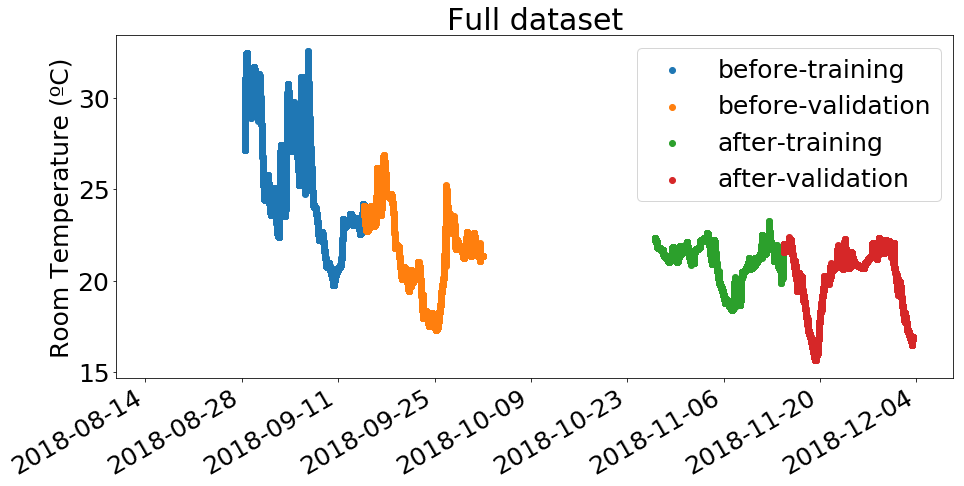

In [258]:
# full dataset
plt.rcParams['font.size'] = 25 # font size
fig, ax = plt.subplots(figsize = (15,7)) # dimensions
ax.xaxis_date() # set_major_formatter(mdates.DateFormatter('%m/%d')) 
ax.scatter(fullrow_bt.index, fullrow_bt.roomC, label = 
           'before-training')
ax.scatter(fullrow_bv.index, fullrow_bv.roomC, label = 
           'before-validation')
ax.scatter(fullrow_at.index, fullrow_at.roomC, label = 
           'after-training')
ax.scatter(fullrow_av.index, fullrow_av.roomC, label = 
           'after-validation')
ax.legend()
ax.set_ylabel('Room Temperature (ºC)')
fig.autofmt_xdate()
ax.set_title('Full dataset');
plt.savefig('Plots/021319/fullrow_abtv.png')

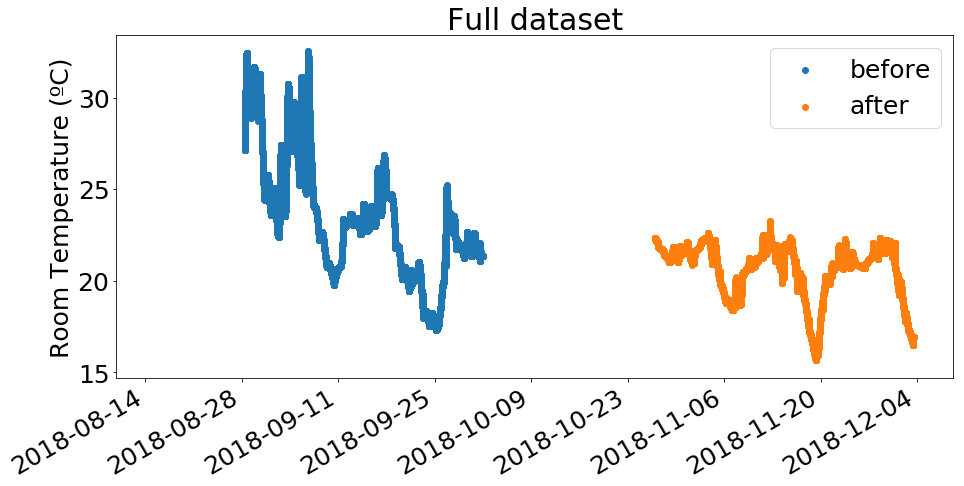

In [257]:
# full dataset
plt.rcParams['font.size'] = 25 # font size
fig, ax = plt.subplots(figsize = (15,7)) # dimensions
ax.xaxis_date() # set_major_formatter(mdates.DateFormatter('%m/%d')) 
ax.scatter(fullrow_b.index, fullrow_b.roomC, label = 'before')
ax.scatter(fullrow_a.index, fullrow_a.roomC, label = 'after')
ax.legend()
ax.set_ylabel('Room Temperature (ºC)')
fig.autofmt_xdate()
ax.set_title('Full dataset');
plt.savefig('Plots/021319/fullrow_ab.png')

In [234]:
list(fullrow_at) # column headers- variables to be chosen in MATLAB

['blinds',
 'heatstat',
 'heatvalve',
 'heatvalvestat',
 'occ',
 'occ31',
 'occ33',
 'positR',
 'positS',
 'qfresh',
 'rain',
 'startpulsevent',
 'ventmode',
 'co2',
 'humid',
 'humid31',
 'humid33',
 'humid22',
 'humid23',
 'oatC',
 'temp31',
 'temp33',
 'temp23',
 'temp22',
 'roomC',
 'slabC',
 'setC',
 'windir',
 'windsp']